<a href="https://colab.research.google.com/github/Jaseelkt007/ML/blob/master/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition
Human Activity Recognition (HAR) is a problem that is an active research field in pervasive computing. An HAR system has the main goal of analyzing human activities by observing and interpreting ongoing events successfully (from sensory data)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


label shape: (1214, 5)
Accelerometer data shape: (20598, 3)
act dict :{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING', 7: 'STAND_TO_SIT', 8: 'SIT_TO_STAND', 9: 'SIT_TO_LIE', 10: 'LIE_TO_SIT', 11: 'STAND_TO_LIE', 12: 'LIE_TO_STAND'}
[[    1     1     2 14069 14699]
 [    1     1     2 15712 16377]
 [    1     1     2 17298 17970]
 [    2     1     2 14128 14783]
 [    2     1     2 15920 16598]]


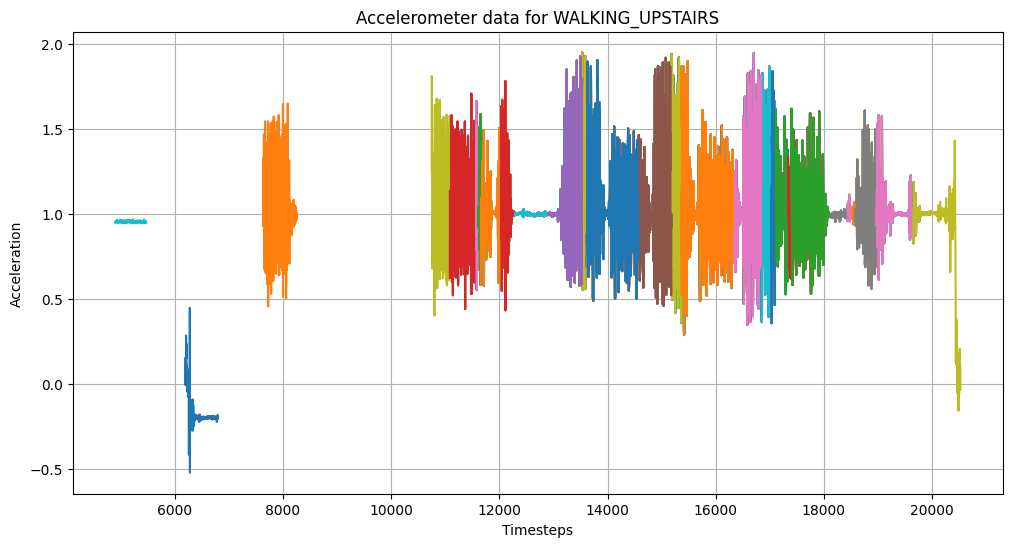

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Visualization Data

data_path = "/content/drive/MyDrive/HAR_dataset/RawData"
all_files = "/content/drive/MyDrive/HAR_dataset"

acc_file = os.path.join(data_path, "acc_exp01_user01.txt")
acc_data = np.loadtxt(acc_file)

label_files = os.path.join(data_path, "labels.txt")
labels = np.loadtxt(label_files, dtype=int)

print("label shape:", labels.shape)
print("Accelerometer data shape:", acc_data.shape)

activity_labels_path = os.path.join(all_files, "activity_labels.txt")
activity_labels = []
with open(activity_labels_path, "r")as f:
    for line in f:
        parts = line.strip().split()
        activity_labels.append((int(parts[0]), " ".join(parts[1:])))
activity_dict = dict(activity_labels)
print(f"act dict :{activity_dict}")

activity_id =2
activity_name = activity_dict[activity_id]

# Extract the row for choosen activity
activity_segment = labels[labels[:,2] == activity_id]
print(activity_segment[:5])
time_steps = np.arange(acc_data.shape[0])

plt.figure(figsize=(12,6))
for segments in activity_segment:
    start_idx, end_idx = segments[3], segments[4]
    plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,0], label="Acc X")
    #plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,1], label="Acc Y")
    #plt.plot(time_steps[start_idx:end_idx], acc_data[start_idx:end_idx,2], label="Acc Z")

plt.title(f"Accelerometer data for {activity_name}")
plt.xlabel("Timesteps")
plt.ylabel("Acceleration")
#plt.legend()
plt.grid()
plt.show()

In [9]:
from re import S
# Initial Preprocessing

import tensorflow as tf
import numpy as np
import os
import time

data_dir = "/content/drive/MyDrive/HAR_dataset/RawData"
label_path = os.path.join(data_dir, "labels.txt")
batch_size = 64

"""
1. Load data and combine the accelerometer and gyroscore data row wise
2. normalize the combined data column wise for each train, val, test data seperatly
3. create the experiment length list -> contain length of each experiments
4. parse and create the label tensor for combined data based on label.txt
5. combine the data and labels and create the sliding window
"""

def cal_exp_lengths(data_path, file_prefix ='acc_exp', file_suffix=".txt"):
    # set initial experiment to 0.
    exp_length =[0]
    filenames = sorted(os.listdir(data_path))
    for file in filenames:
        if file.startswith(file_prefix) and file.endswith(file_suffix):
            file_path = os.path.join(data_path,file)
            num_rows = np.loadtxt(file_path).shape[0]
            exp_length.append(num_rows)
    return exp_length


def parse_labels(label_file_path, exp_lengths):
    segments =[]
    cumulative_offset = 0
    current_experiment_id = -1
    with open(label_file_path,'r') as f:
        for line in f:
            parts = line.strip().split()
            exp_id = int(parts[0])
            act_id = int(parts[2])
            start_idx = int(parts[3])
            end_idx = int(parts[4])

            # Update the cummulative offset for next experiment
            if exp_id != current_experiment_id:
                cumulative_offset += exp_lengths[exp_id -1] # Add previous exp length , intial element in exp_len = 0
                current_experiment_id = exp_id

            adjusted_start_idx = start_idx + cumulative_offset
            adjusted_end_idx = end_idx + cumulative_offset

            segments.append({
                "activity_id" : act_id,
                "start_idx" : adjusted_start_idx,
                "end_idx" : adjusted_end_idx
            })
    return segments


def create_label_tensor(segments, total_time_steps):
    label_tensor = np.zeros(total_time_steps, dtype=int)
    for segment in segments:
      activity_id = segment["activity_id"]
      start_idx = segment["start_idx"]
      end_idx = segment["end_idx"]

      # Update label_array
      label_tensor[start_idx:end_idx] = activity_id
    return label_tensor

def sliding_window(dataset, window_size =128, overlap = 0.5):

    # Convert data and labels into tf.data.Dataset object
    step_size = int(window_size*(1 - overlap))

    # data_ds = tf.data.Dataset.from_tensor_slices(data)
    # labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Combine data and label
    # dataset = tf.data.Dataset.zip((data_ds, labels_ds))

    # Create the sliding window
    dataset = dataset.window(size=window_size, shift=step_size, drop_remainder=True)

    # batch into windows and flatten the dataset
    def create_windowed_dataset(data_ds, labels_ds):
        windowed_data = data_ds.batch(window_size, drop_remainder=True)
        windowed_labels = labels_ds.batch(window_size, drop_remainder = True)
        return tf.data.Dataset.zip((windowed_data, windowed_labels))
    dataset = dataset.flat_map(create_windowed_dataset)

    # Calcualte the most frequent label
    def most_frequent_labels(window_labels):
        unique_labels , _ , counts = tf.unique_with_counts(window_labels)
        return unique_labels[tf.argmax(counts)]

    dataset = dataset.map(lambda window_data, window_labels : (window_data,most_frequent_labels(window_labels)))

    return dataset

def augment(data, label):
    jitter = tf.random.uniform(data.shape, minval = -0.1, maxval = 0.1)
    scaled_data = data + jitter
    scale_factor = tf.random.uniform([], minval=0.9 , maxval=1.1)
    scaled_data = scaled_data * scale_factor
    return scaled_data , label

def oversample_and_augment(data, label, minority_classes, oversample_factor=2, debug=True):
    # Identify minority and majority class indices
    minority_mask = tf.reduce_any([label == c for c in minority_classes], axis=0) # do logic OR along colum wise
    majority_mask = ~minority_mask

    # Filter out the  minority and majority data based on the masks
    minority_data = tf.boolean_mask(data, minority_mask)
    minority_labels = tf.boolean_mask(label, minority_mask)

    majority_data = tf.boolean_mask(data, majority_mask)
    majority_labels = tf.boolean_mask(label, majority_mask)

    # Ensure data types are consistent
    minority_data = tf.cast(minority_data, tf.float32)
    majority_data = tf.cast(majority_data, tf.float32)
    minority_labels = tf.cast(minority_labels, tf.int64)
    majority_labels = tf.cast(majority_labels, tf.int64)

    if debug:
        print("Minority class counts before oversampling:")
        for c in minority_classes:
            print(f"Class {c}: {tf.reduce_sum(tf.cast(label == c, tf.int32)).numpy()}")

    # Oversample and augment the minority class samples
    start_time = time.time()
    print("Over sampling using .repeat")
    oversampled_data = tf.repeat(minority_data, repeats=oversample_factor, axis=0)
    oversampled_labels = tf.repeat(minority_labels, repeats=oversample_factor, axis=0)
    end_time = time.time()
    print(f"Completed.\nOversampled data shape: {oversampled_data.shape}")
    print(f"Total time taken to oversample data: {end_time - start_time} seconds")

    def augment(data, label):
        jitter = tf.random.uniform(data.shape, minval=-0.1, maxval=0.1)
        scaled_data = data + jitter
        scale_factor = tf.random.uniform([], minval=0.9, maxval=1.1)
        scaled_data = scaled_data * scale_factor
        return scaled_data, label

    # Combine the oversampled data back with the majority class
    start_time = time.time()
    print("Combining oversampled and majority data...")
    combined_data = tf.concat([majority_data, oversampled_data], axis=0)
    combined_labels = tf.concat([majority_labels, oversampled_labels], axis=0)
    end_time = time.time()
    print(f"Completed.\nCombined data shape: {combined_data.shape}")
    print(f"Total time taken to combine data: {end_time - start_time} seconds")

    if debug:
        print("Minority class counts after oversampling:")
        for c in minority_classes:
            print(f"Class {c}: {tf.reduce_sum(tf.cast(combined_labels == c, tf.int32)).numpy()}")
        print(f"Total samples after oversampling: {combined_labels.shape[0]}")

    dataset = tf.data.Dataset.from_tensor_slices((combined_data,combined_labels))
    dataset = dataset.shuffle(buffer_size=1000)

    return dataset

def load(batch_size ,data_path, labels_file):
    acc_files = sorted([ f for f in os.listdir(data_path) if f.startswith("acc")])
    gyro_files = sorted([f for f in os.listdir(data_path) if f.startswith("gyro")])
    combined_data = []

    ds_train = []
    ds_val = []
    ds_test = []

    for acc_file, gyro_file in zip(acc_files, gyro_files):

        acc_file_path = os.path.join(data_dir, acc_file)
        gyro_file_path = os.path.join(data_dir, gyro_file)
        acc_data = tf.convert_to_tensor(np.loadtxt(acc_file_path), dtype=tf.float32)
        gyro_data = tf.convert_to_tensor(np.loadtxt(gyro_file_path), dtype=tf.float32)
        combined = tf.concat([acc_data, gyro_data], axis=1)

        # Extract user ID from filename
        user_id = int(acc_file.split('_user')[1].split('.txt')[0]) # eg: acc_exp44_user22.txt

        if 1 <= user_id <= 21:
            ds_train.append(combined)
        elif 28 <= user_id <= 30:
            ds_val.append(combined)
        elif 22 <= user_id <= 27:
            ds_test.append(combined)


    start_time = time.time()
    print("Concatenating data...")
    ds_train = tf.concat(ds_train, axis=0)  # aixs = 0 means vertical concatenation
    print(f'Completed.\nds_train shape: {ds_train.shape}')

    ds_val = tf.concat(ds_val, axis=0)
    print(f'Completed.\nds_val shape: {ds_val.shape}')

    ds_test = tf.concat(ds_test, axis=0)
    print(f'Completed.\nds_test shape: {ds_test.shape}')
    end_time = time.time()
    print(f"Total time taken to concatenate data: {end_time - start_time} seconds")

    experiment_length = cal_exp_lengths(data_dir)
    total_time_steps = sum(experiment_length)
    segments = parse_labels(labels_file, exp_lengths=experiment_length)
    label_tensor = create_label_tensor(segments, total_time_steps)

    # Calculate cumulative lengths for splitting
    train_length = ds_train.shape[0]
    val_length = ds_val.shape[0]
    test_length = ds_test.shape[0]
    print(f"train_length:{train_length}")
    print(f"val_length:{val_length}")
    print(f"test_length:{test_length}")
    # Split label_tensor
    train_labels = label_tensor[:train_length]
    test_labels = label_tensor[train_length:train_length+test_length]
    val_labels = label_tensor[train_length + test_length:]
    print(f"train_labels:{train_labels}")
    print(f"test_labels:{test_labels}")
    print(f"val_labels:{val_labels}")
    # Prepare
    ds_train, ds_val, ds_test = prepare(ds_train, ds_val, ds_test, train_labels, val_labels, test_labels, batch_size)

    return ds_train, ds_val, ds_test, batch_size

def prepare(ds_train, ds_val, ds_test, train_labels, val_labels, test_labels , batch_size,ds_info=None, caching=True):
    """Prepare datasets with preprocessing, batching, caching, and prefetching"""

    def prepare_dataset(data, labels, batch_size, window_size =128, overlap = 0.5, shuffle_buffer = 1000, cache = True , is_training=True,
                        minority_classes=None, oversample_factor=3, debug=False):
        # Step 1 : Normalize the data
        start_time = time.time()
        print("Normalizing data...")
        data = preprocess(data)
        end_time = time.time()
        print(f"Completed.\nNormalized data shape: {data.shape}")
        print(f"Total time taken to normalize data: {end_time - start_time} seconds")

        if is_training and minority_classes:
            start_time = time.time()
            print("Oversampling and augmenting data...")
            datasets = oversample_and_augment(data, labels, minority_classes, oversample_factor=oversample_factor,debug=debug)
            end_time = time.time()
            print(f"Completed.\nOversampled and augmented data shape: {data.shape}")
            print(f"Total time taken to oversample and augment data: {end_time - start_time} seconds")
        else:
            datasets = tf.data.Dataset.from_tensor_slices((data, labels))
        # Step 2 : Create sliding window
        start_time = time.time()
        dataset = sliding_window(datasets, window_size=window_size, overlap=overlap)
        end_time = time.time()
        print(f"Total time taken to create sliding window: {end_time - start_time} seconds")

        # Step 3 : since previous steps are deterministic, caching is done before preprocessing
        if cache:
            dataset = dataset.cache()

        if is_training:
            start_time = time.time()
            print("Augmenting data...")
            dataset = dataset.map(augment , num_parallel_calls=tf.data.AUTOTUNE)
            end_time = time.time()
            print(f"Completed.\nAugmented data shape: {data.shape}")
            print(f"Total time taken to augment data: {end_time - start_time} seconds")

        if is_training:
            dataset = dataset.shuffle(shuffle_buffer).repeat()
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset

    # Prepare datasets
    ds_train = prepare_dataset(ds_train, train_labels, batch_size, cache= True, minority_classes = minority_classes, debug= True)
    start_time = time.time()
    print("Preparing validation dataset...")
    ds_val = prepare_dataset(ds_val, val_labels, batch_size, cache= True,is_training=False,)
    end_time = time.time()
    print(f"Completed.\nTotal time taken to prepare validation dataset: {end_time - start_time} seconds")
    start_time = time.time()
    print("Preparing test dataset...")
    ds_test = prepare_dataset(ds_test, test_labels, batch_size,cache= True,is_training=False,)
    end_time = time.time()
    print(f"Completed.\nTotal time taken to prepare test dataset: {end_time - start_time} seconds")

    return ds_train, ds_val, ds_test


def preprocess(data):
    mean = tf.reduce_mean(data, axis=0)
    std = tf.math.reduce_std(data, axis=0)
    return (data - mean)/ std

minority_classes = [7,8,9,10,11,12]

ds_train, ds_val, ds_test , batch_size = load(batch_size, data_dir, label_path)

# datasets = [
#     ("train", ds_train),
#     ("val", ds_val),
#     ("test", ds_test)
#     ]

# for name, dataset in datasets:
#     print(f"Processing the dataset of {name}...")
#     for window_data, window_labels in dataset.take(10):
#         print("Window Data Shape: ", window_data.shape)
#         print("Window Labels Shape :", window_labels.shape)
#         print("Window Labels : ",window_labels.numpy())
#         print("="*50)

Concatenating data...
Completed.
ds_train shape: (770774, 6)
Completed.
ds_val shape: (118571, 6)
Completed.
ds_test shape: (233427, 6)
Total time taken to concatenate data: 0.011918306350708008 seconds
train_length:770774
val_length:118571
test_length:233427
train_labels:[0 0 0 ... 0 0 0]
test_labels:[0 0 0 ... 0 0 0]
val_labels:[0 0 0 ... 0 0 0]
Normalizing data...
Completed.
Normalized data shape: (770774, 6)
Total time taken to normalize data: 0.0812387466430664 seconds
Oversampling and augmenting data...
Minority class counts before oversampling:
Class 7: 7149
Class 8: 5525
Class 9: 8560
Class 10: 7922
Class 11: 10831
Class 12: 7521
Over sampling using .repeat
Completed.
Oversampled data shape: (142524, 6)
Total time taken to oversample data: 0.0072438716888427734 seconds
Combining oversampled and majority data...
Completed.
Combined data shape: (865790, 6)
Total time taken to combine data: 0.012843608856201172 seconds
Minority class counts after oversampling:
Class 7: 21447
Class

In [ ]:
def split_dataset(dataset , train_split =0.7, val_split=0.1, test_split = 0.2):
    total_size = sum(1 for _ in dataset)
    train_size = int(total_size * train_split)
    val_size = int(total_size * val_split)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    return train_ds , val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(sliding_window_data,train_split =0.7, val_split=0.1, test_split = 0.2)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
for data, labels in train_ds.take(1): # take a single batch
    print("Data shape: ", data.shape)
    print("Labels shape : ", labels.shape)

Data shape:  (32, 128, 6)
Labels shape :  (32,)


In [ ]:
# Next steps:

"""
1. Use Augmentation to increase minority samples
2. Use weighted Loss for Balanced Learning
"""

class_weights = {
    1: 1.0,  # WALKING
    2: 1.0,  # WALKING_UPSTAIRS
    3: 1.0,  # WALKING_DOWNSTAIRS
    4: 0.5,  # SITTING
    5: 0.5,  # STANDING
    6: 0.5,  # LAYING
    7: 2.0,  # STAND_TO_SIT
    8: 2.0,  # SIT_TO_STAND
    9: 2.0,  # SIT_TO_LIE
    10: 2.0, # LIE_TO_SIT
    11: 2.0, # STAND_TO_LIE
    12: 2.0  # LIE_TO_STAND
}
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
weighted_loss_fn = lambda y_true, y_pred: loss_fn(y_true, y_pred) * class_weights[tf.argmax(y_true, axis=-1)]